In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# suppress Future Warnings due to diff in library versions...
warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
# load CSV file
df = pd.read_csv('Project Dataset.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   MaritalStatus                5630 non-null   object 
 7   AgeGroup                     5630 non-null   int64  
 8   Gender                       5630 non-null   object 
 9   HourSpendOnApp               5375 non-null   float64
 10  OrderCount                   5372 non-null   float64
 11  OrderAmountHikeFromlastYear  5365 non-null   float64
 12  DaySinceLastOrder            5323 non-null   float64
 13  PreferedOrderCat  

In [28]:
# total number of entries before cleaning
print("Total number of entries (rows) before cleaning:", len(df))

Total number of entries (rows) before cleaning: 5630


In [29]:
# check for missing values and data types per column
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
MaritalStatus                    0
AgeGroup                         0
Gender                           0
HourSpendOnApp                 255
OrderCount                     258
OrderAmountHikeFromlastYear    265
DaySinceLastOrder              307
PreferedOrderCat                 0
NumberOfStreamerFollowed         0
SatisfactionScore                0
Complain                         0
CouponUsed                     256
DiscountAmount                   0
dtype: int64


In [30]:
# remove rows with any missing values
# df_cleaned = df.dropna()
df_cleaned = df.copy()
# remove duplicated entries if any
df_cleaned = df_cleaned.drop_duplicates()

# drop columns that have negative values
columns_to_check = [
    'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderCount', 
    'OrderAmountHikeFromlastYear', 'DaySinceLastOrder', 'CouponUsed', 
    'DiscountAmount'
]

# for column in columns_to_check:
#     df_cleaned = df_cleaned[df_cleaned[column] >= 0]

# replace 'Phone' with 'PC' in the 'PreferredLoginDevice' column, because 'Phone' is an error and duplicates the 'Mobile Phone' category
df_cleaned['PreferredLoginDevice'] = df_cleaned['PreferredLoginDevice'].replace('Phone', 'PC')

# verify the changes
print(df_cleaned['PreferredLoginDevice'].value_counts())
print("Total number of entries (rows) after cleaning:", len(df_cleaned))

PreferredLoginDevice
Mobile Phone    2765
Pad             1634
PC              1231
Name: count, dtype: int64
Total number of entries (rows) after cleaning: 5630


In [31]:
df_cleaned.to_csv("Cleaned_Dataset.csv")

In [32]:
df_cleaned['PreferredLoginDevice'], uniques_PD = pd.factorize(df_cleaned['PreferredLoginDevice'])
df_cleaned['MaritalStatus'], uniques_MS = pd.factorize(df_cleaned['MaritalStatus'])
df_cleaned['Gender'], uniques_GD = pd.factorize(df_cleaned['Gender'])
df_cleaned['PreferedOrderCat'], uniques_GD = pd.factorize(df_cleaned['PreferedOrderCat'])

df_cleaned.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,MaritalStatus,AgeGroup,Gender,HourSpendOnApp,OrderCount,OrderAmountHikeFromlastYear,DaySinceLastOrder,PreferedOrderCat,NumberOfStreamerFollowed,SatisfactionScore,Complain,CouponUsed,DiscountAmount
0,50001,1,4.0,0,3,6.0,0,3,0,3.0,1.0,11.0,5.0,0,9,2,1,1.0,160
1,50002,1,NaN,1,1,8.0,0,4,1,3.0,1.0,15.0,0.0,1,7,3,1,0.0,121
2,50003,1,NaN,1,1,30.0,0,4,1,2.0,1.0,14.0,3.0,1,6,3,1,0.0,120
3,50004,1,3.0,1,3,15.0,0,4,1,2.0,1.0,23.0,3.0,0,8,5,0,0.0,134
4,50005,1,3.0,1,1,12.0,0,3,1,NaN,1.0,11.0,3.0,1,3,5,0,1.0,130


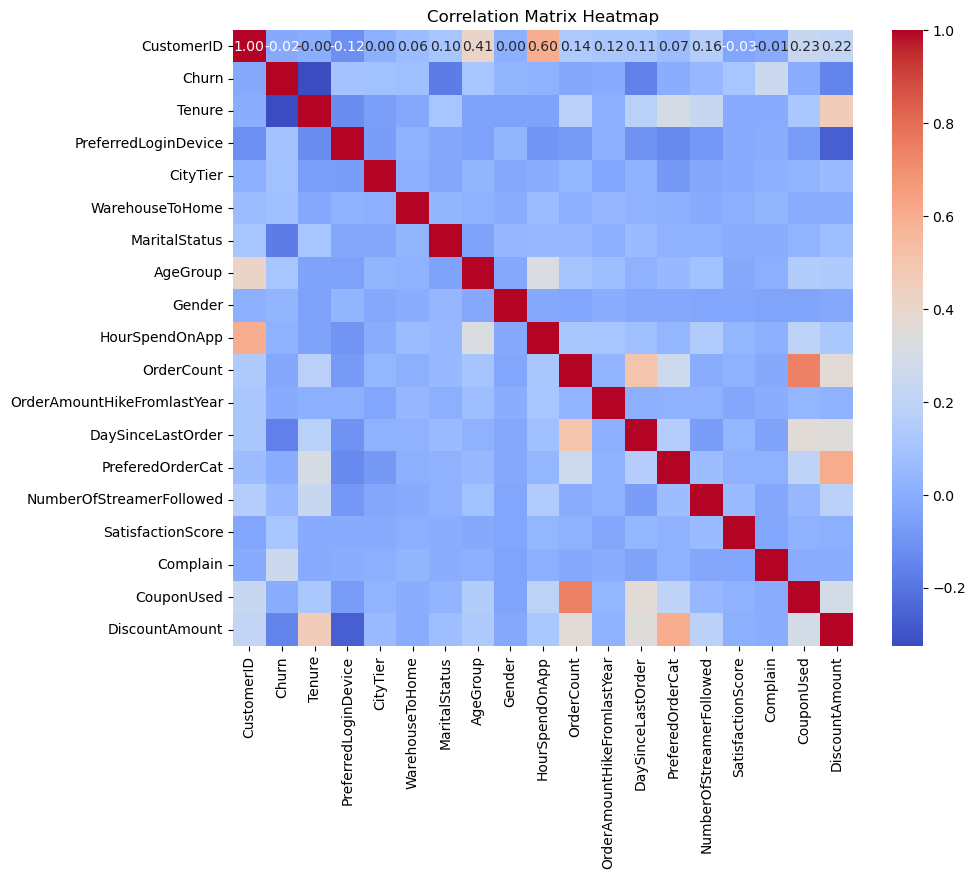

In [33]:
correlation_matrix = df_cleaned.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [34]:
result_df = pd.DataFrame()

# 对每个类别进行分组
for category, group in df_cleaned.groupby('PreferedOrderCat'):
    # 使用 SimpleImputer 填充中值
    imputer = SimpleImputer(strategy='median')
    # 注意：fit_transform 只对数值列生效
    filled_group = pd.DataFrame(imputer.fit_transform(group.drop(columns=['PreferedOrderCat'])), 
                                columns=group.columns.drop('PreferedOrderCat'),
                                index=group.index)
    
    # 添加类别列
    filled_group['PreferedOrderCat'] = category
    
    # 合并结果
    result_df = pd.concat([result_df, filled_group], axis=0)

# 重新排序索引
result_df = result_df.sort_index()

print(result_df)

      CustomerID  Churn  Tenure  PreferredLoginDevice  CityTier  \
0        50001.0    1.0     4.0                   0.0       3.0   
1        50002.0    1.0     4.0                   1.0       1.0   
2        50003.0    1.0     4.0                   1.0       1.0   
3        50004.0    1.0     3.0                   1.0       3.0   
4        50005.0    1.0     3.0                   1.0       1.0   
...          ...    ...     ...                   ...       ...   
5625     55626.0    0.0    13.0                   2.0       1.0   
5626     55627.0    0.0    13.0                   0.0       1.0   
5627     55628.0    0.0     1.0                   0.0       1.0   
5628     55629.0    0.0    23.0                   2.0       3.0   
5629     55630.0    0.0     8.0                   0.0       1.0   

      WarehouseToHome  MaritalStatus  AgeGroup  Gender  HourSpendOnApp  \
0                 6.0            0.0       3.0     0.0             3.0   
1                 8.0            0.0       4.0 

In [35]:
result_df.to_csv('result_df.csv')

Cumulative Variance Ratio: [0.99971215 0.9999322  0.99996067 0.9999822  0.99998747 0.99999242
 0.99999466 0.99999661 0.99999737 0.99999806 0.99999844 0.9999988
 0.99999911 0.99999939 0.99999966 0.99999979 0.99999988 0.99999996
 1.        ]


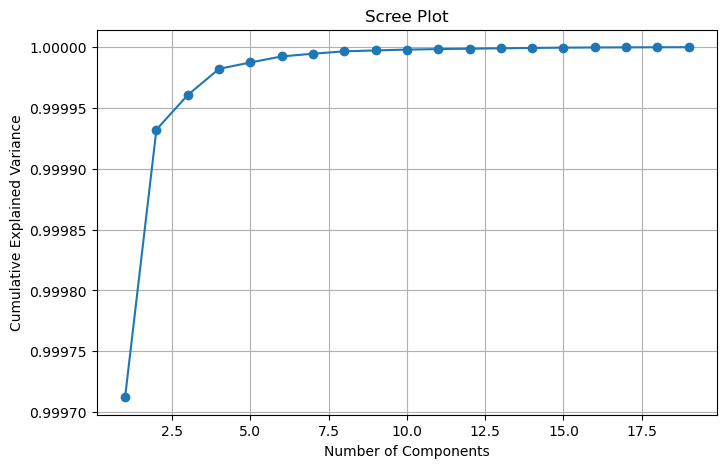

In [ ]:
df = df_cleaned
complete_cases = df.dropna()

# Perform PCA
pca = PCA()
pca.fit(df)

# Cumulative variance ratio
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
print("Cumulative Variance Ratio:", cumulative_variance_ratio)

# Plot Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [41]:
df_cleaned

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,MaritalStatus,AgeGroup,Gender,HourSpendOnApp,OrderCount,OrderAmountHikeFromlastYear,DaySinceLastOrder,PreferedOrderCat,NumberOfStreamerFollowed,SatisfactionScore,Complain,CouponUsed,DiscountAmount
0,50001,1,4.0,0,3,6.0,0,3,0,3.0,1.0,11.0,5.0,0,9,2,1,1.0,160
1,50002,1,NaN,1,1,8.0,0,4,1,3.0,1.0,15.0,0.0,1,7,3,1,0.0,121
2,50003,1,NaN,1,1,30.0,0,4,1,2.0,1.0,14.0,3.0,1,6,3,1,0.0,120
3,50004,1,3.0,1,3,15.0,0,4,1,2.0,1.0,23.0,3.0,0,8,5,0,0.0,134
4,50005,1,3.0,1,1,12.0,0,3,1,NaN,1.0,11.0,3.0,1,3,5,0,1.0,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,13.0,2,1,30.0,2,2,1,3.0,2.0,18.0,4.0,0,6,1,0,1.0,151
5626,55627,0,13.0,0,1,13.0,2,5,1,3.0,2.0,16.0,NaN,4,6,5,0,1.0,225
5627,55628,0,1.0,0,1,11.0,2,2,1,3.0,2.0,21.0,4.0,0,3,4,1,1.0,186
5628,55629,0,23.0,2,3,9.0,2,5,1,4.0,2.0,15.0,9.0,0,4,4,0,2.0,179


In [43]:
df = df_cleaned.copy()

# Fill missing values initially to perform PCA
initial_imputer = SimpleImputer(strategy='mean')
imputed_data = initial_imputer.fit_transform(df)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(imputed_data)

# Use KMeans for clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Add clustering results to the DataFrame
df['Cluster'] = clusters

# Fill missing values based on clustering results
result_df = pd.DataFrame()

for cluster, group in df.groupby('Cluster'):
    # Fill missing values with the median for each cluster
    imputer = SimpleImputer(strategy='median')
    filled_group = pd.DataFrame(imputer.fit_transform(group.drop(columns=['Cluster'])), 
                                columns=group.columns.drop(['Cluster']),
                                index=group.index)
    
    # Add cluster column back
    filled_group['Cluster'] = cluster
    
    # Concatenate results
    result_df = pd.concat([result_df, filled_group], axis=0)

# Re-sort index
result_df = result_df.sort_index()

print(result_df)

      CustomerID  Churn  Tenure  PreferredLoginDevice  CityTier  \
0        50001.0    1.0     4.0                   0.0       3.0   
1        50002.0    1.0     8.0                   1.0       1.0   
2        50003.0    1.0     8.0                   1.0       1.0   
3        50004.0    1.0     3.0                   1.0       3.0   
4        50005.0    1.0     3.0                   1.0       1.0   
...          ...    ...     ...                   ...       ...   
5625     55626.0    0.0    13.0                   2.0       1.0   
5626     55627.0    0.0    13.0                   0.0       1.0   
5627     55628.0    0.0     1.0                   0.0       1.0   
5628     55629.0    0.0    23.0                   2.0       3.0   
5629     55630.0    0.0     8.0                   0.0       1.0   

      WarehouseToHome  MaritalStatus  AgeGroup  Gender  HourSpendOnApp  \
0                 6.0            0.0       3.0     0.0             3.0   
1                 8.0            0.0       4.0 

In [44]:
result_df.to_csv('pca_df.csv')